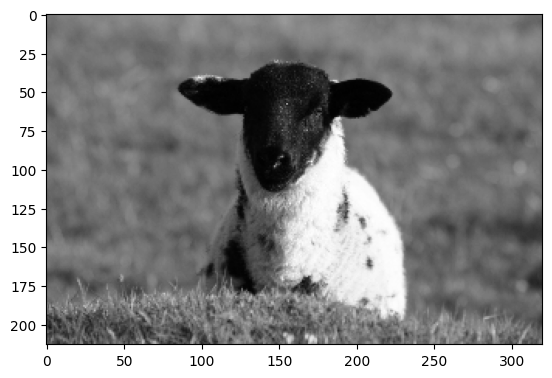

In [130]:
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
import cv2

# Path: main.ipynb

img = cv2.imread('./images/1_27_s.bmp', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/6_12_s.bmp', cv2.IMREAD_GRAYSCALE)

# display image
plt.imshow(img, cmap='gray')
plt.show()

In [3]:
def convolve(img, kernel) -> np.ndarray:
    # get dimensions of image and kernel
    h, w = img.shape
    kh, kw = kernel.shape
    conv = np.zeros((h, w))

    # some padding
    img = np.pad(img, (kh//2, kw//2), 'constant')

    @numba.jit(nopython=True)
    def process(img, h, w, kh, kw, conv):
        # iterate over image
        for x in range(h):
            for y in range(w):
                conv[x, y] = (kernel * img[x: x+kh, y: y+kw]).sum()
        return conv

    return process(img, h, w, kh, kw, conv)

def log(i, j, sigma):
    return (-1)/(np.pi * sigma**4) * (1 - (i**2 + j**2)/(2*sigma**2)) * np.exp(-(i**2+j**2)/(2*sigma**2))

def laplacian_of_gaussian(dim, sigma=1, k=1):
    kernel = np.zeros((dim, dim)) 
    for i in range(-dim//2, dim//2+1):
        for j in range(-dim//2, dim//2+1):
            kernel[i+dim//2, j+dim//2] = log(i, j, sigma)

    return sigma**2 * kernel

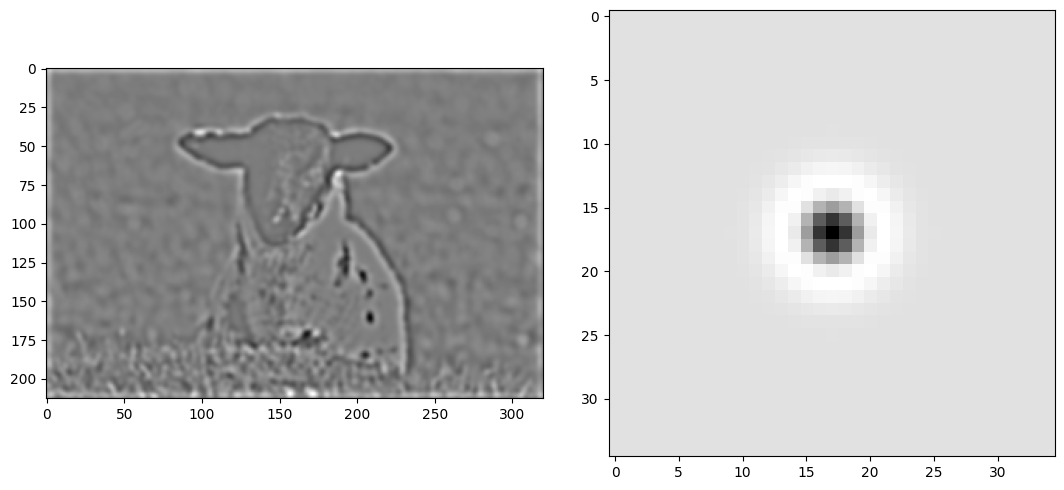

In [4]:
kernel = laplacian_of_gaussian(35, 2)
fig, axs = plt.subplots(1,2, figsize=(11, 5))

axs[0].imshow(convolve(img, -kernel), cmap='gray')
axs[1].imshow(kernel, cmap='gray')
fig.tight_layout()

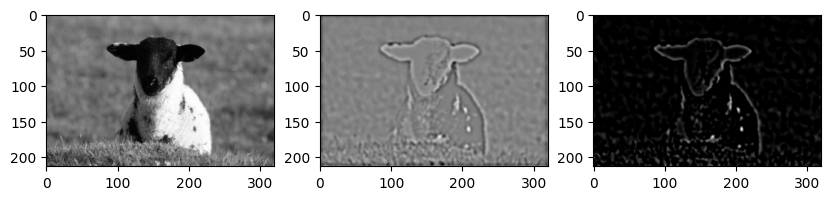

In [6]:
filtered = convolve(img, kernel)
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].imshow(img, cmap='gray')
axs[1].imshow(filtered, cmap='gray')
axs[2].imshow(cv2.filter2D(img, -10, kernel), cmap='gray')
plt.show()

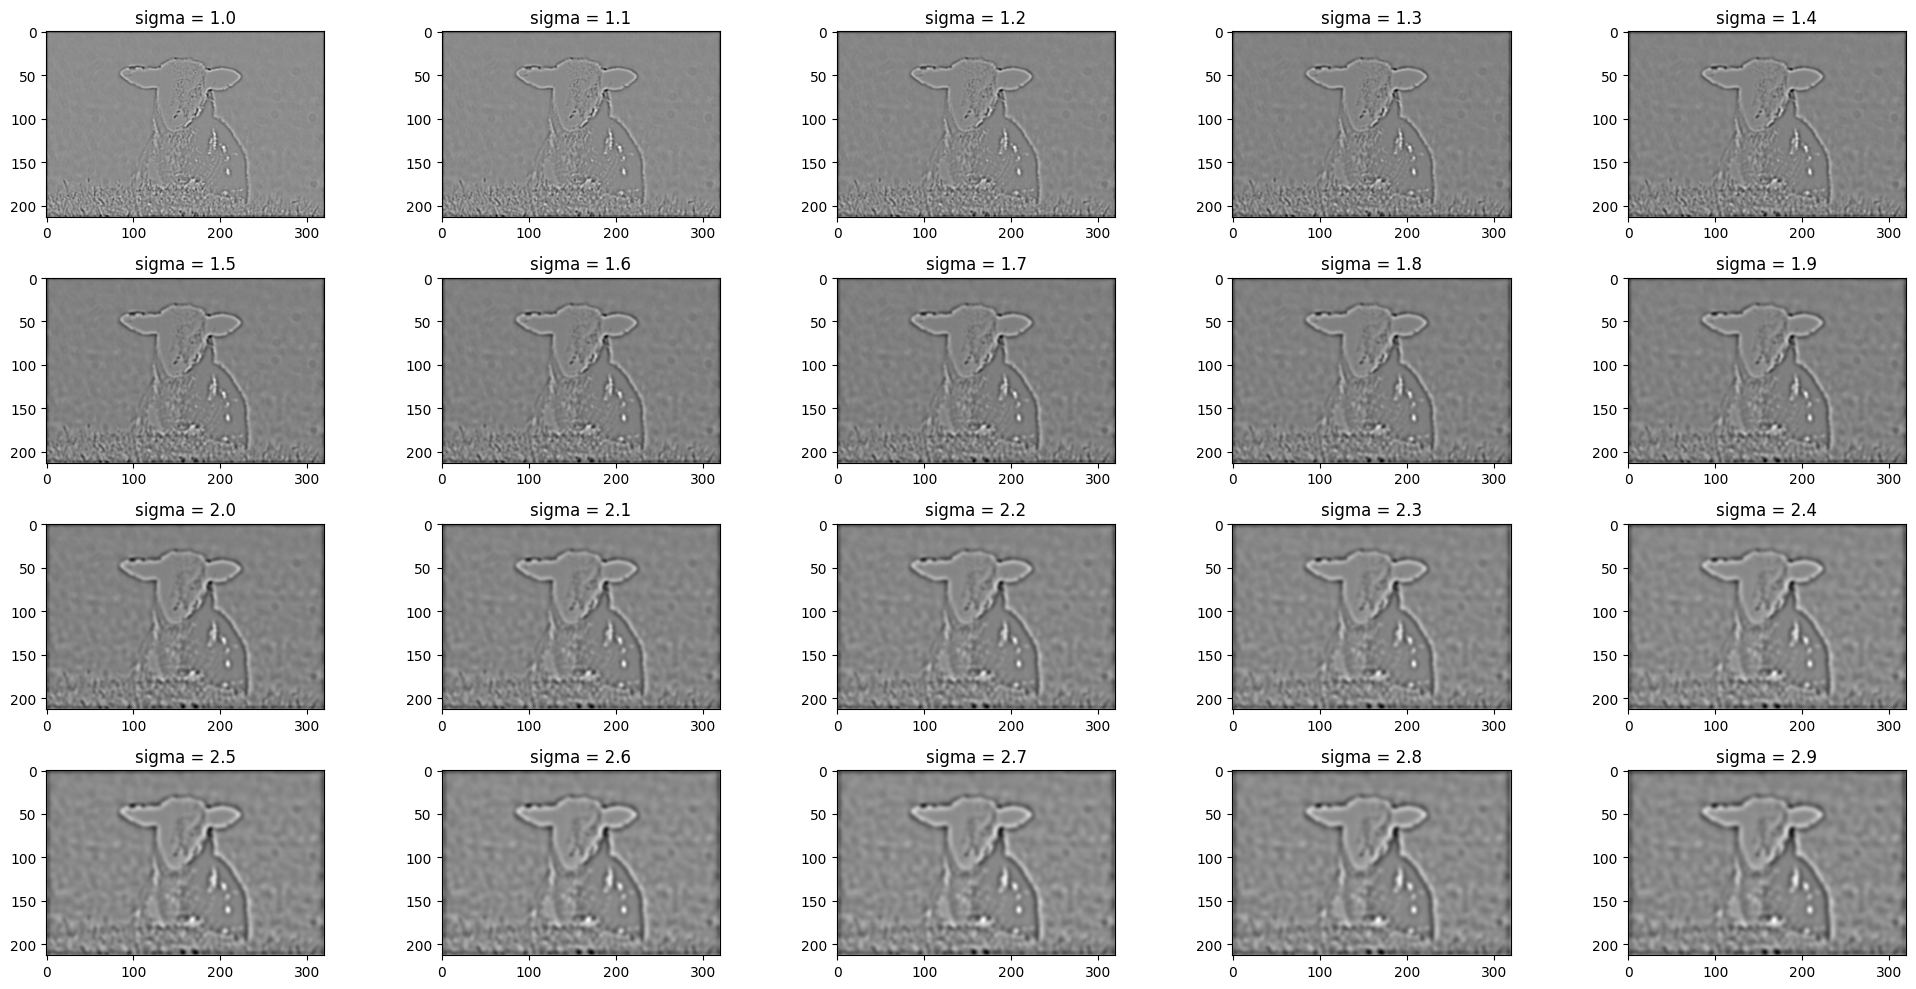

In [7]:
# try 10 values of sigma and plot it in range 1.5 to 2.5 with step 0.1
sigmas = np.arange(1, 3, 0.1)
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i, sigma in enumerate(sigmas):
    kernel = laplacian_of_gaussian(35, sigma)
    filtered = convolve(img, kernel)
    axs[i//5, i%5].imshow(filtered, cmap='gray')
    axs[i//5, i%5].set_title(f'sigma = {round(sigma,2)}')
fig.tight_layout()

In [11]:
filtered = convolve(img, laplacian_of_gaussian(35, 2))
np.max(filtered), np.min(filtered), np.mean(filtered)

(83.00421146107657, -86.38284488502039, -1.4214178601142662)

In [121]:
def detect_blobs(img, threshold=1):
    kernels = [laplacian_of_gaussian(35, s) for s in range(1, 4, 1)]
    height, width = img.shape
    filtered = [convolve(img, kernel) for kernel in kernels]
    filtered = [np.pad(i, (3, 3), 'constant') for i in filtered]
    filtered = np.array(filtered)
    blob_cords = []
   
    for x in range(1, height):
        for y in range(1, width):
            region = filtered[:, x-1:x+2, y-1:y+2]
            candidate_max = np.amax(region)
            scale, h, w = np.unravel_index(np.argmax(region), region.shape)
            if candidate_max > threshold:
                blob_cords.append((scale+1, x+h, y+w))
                
    return np.array(blob_cords)

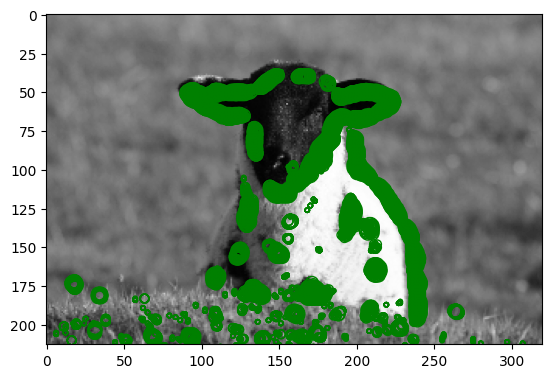

In [131]:
blobs = detect_blobs(img, threshold=20)

plt.imshow(img, cmap='gray')
for blob in blobs:
    circle = plt.Circle((blob[2], blob[1]), blob[0]*1.414, color='g', fill=False)
    plt.gca().add_patch(circle)

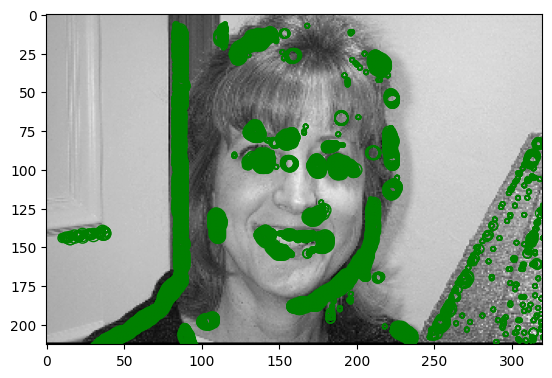

In [129]:
blobs = detect_blobs(img, threshold=20)

plt.imshow(img, cmap='gray')
for blob in blobs:
    circle = plt.Circle((blob[2], blob[1]), blob[0]*1.414, color='g', fill=False)
    plt.gca().add_patch(circle)


In [1]:
def threshold_img(img, sigma, k):
    sigmas = np.array([0.7, 1.2, 1.7])
    convols= np.array([convolve(img, laplacian_of_gaussian(11, sigma)) for sigma in sigmas])
    height, width = img.shape

    # iterate over all pixels and take the argmax of the 3 convolutions

    blobs = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            # look at a 3x3 neighborhood around the pixel
            neighborhood = convols[:, i-1:i+2, j-1:j+2]
            # if the pixel is the maximum in the neighborhood, it is a blob
            if np.argmax(neighborhood) == 4:
                blobs[i, j] = 1


# try 10 values of sigma and plot it in range 1.5 to 2.5 with step 0.1
sigmas = np.arange(0.5, 2.5, 0.1)
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i, sigma in enumerate(sigmas):
    filtered = threshold_img(img, sigma, 0)
    axs[i//5, i%5].imshow(filtered, cmap='gray')
    axs[i//5, i%5].set_title(f'sigma = {round(sigma,2)}')

fig.tight_layout()



NameError: name 'np' is not defined